<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/04_multilingual-ner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [1]:
# 코랩이나 캐글을 사용한다면 이 셀의 주석을 제거하고 실행하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements()

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 150 (delta 25), reused 121 (delta 7), pack-reused 0
Receiving objects: 100% (150/150), 16.67 MiB | 19.38 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [2]:
from utils import *
setup_chapter()

Using transformers v4.11.3
Using datasets v1.16.1


# 다중 언어 개체명 인식

## 데이터셋

In [3]:
import pandas as pd
toks = "Jeff Dean is a computer scientist at Google in California".split()
lbls = ["B-PER", "I-PER", "O", "O", "O", "O", "O", "B-ORG", "O", "B-LOC"]
df = pd.DataFrame(data=[toks, lbls], index=['Tokens', 'Tags'])
df

,0,1,2,3,4,5,6,7,8,9
Tokens,Jeff,Dean,is,a,computer,scientist,at,Google,in,California
Tags,B-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC


In [4]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME 서브셋 개수: {len(xtreme_subsets)}")

Downloading:   0%|          | 0.00/9.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.1k [00:00<?, ?B/s]

XTREME 서브셋 개수: 183


In [5]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [6]:
from datasets import load_dataset

load_dataset("xtreme", name="PAN-X.de")

Downloading:   0%|          | 0.00/234M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
})

In [7]:
from collections import defaultdict
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# 키가 없는 경우 DatasetDict를 반환합니다.
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # 다국어 말뭉치를 로드합니다.
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # 각 분할을 언어 비율에 따라 다운샘플링하고 섞습니다.
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [9]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der',
'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [10]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER',
'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], names_file=None, id=None),
length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [11]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG',
'B-LOC', 'I-LOC'], names_file=None, id=None)


In [12]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/12580 [00:00<?, ?ex/s]

In [13]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [14]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,ORG,LOC,PER
validation,2683,3172,2893
test,2573,3180,3071
train,5366,6186,5810


## 다중 언어 트랜스포머

## XLM-R 토큰화

In [15]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [16]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [17]:
df = pd.DataFrame([bert_tokens, xlmr_tokens], index=["BERT", "XLM-R"])
df

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


### 토큰화 파이프라인

<img alt="Tokenizer pipeline" caption="The steps in the tokenization pipeline" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter04_tokenizer-pipeline.png?raw=1" id="toknizer-pipeline"/>

### SentencePiece 토크나이저

In [18]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

## 개체명 인식을 위한 트랜스포머

<img alt="Architecture of a transformer encoder for classification." caption="Fine-tuning an encoder-based transformer for sequence classification" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter04_clf-architecture.png?raw=1" id="clf-arch"/>

<img alt="Architecture of a transformer encoder for named entity recognition. The wide linear layer shows that the same linear layer is applied to all hidden states." caption="Fine-tuning an encoder-based transformer for named entity recognition" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter04_ner-architecture.png?raw=1" id="ner-arch"/>

## 트랜스포머 모델 클래스

### 바디와 헤드

<img alt="bert-body-head" caption="The `BertModel` class only contains the body of the model, while the `BertFor&lt;Task&gt;` classes combine the body with a dedicated head for a given task" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter04_bert-body-head.png?raw=1" id="bert-body-head"/>

### 토큰 분류를 위한 사용자 정의 모델 만들기

In [19]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # 모델 바디를 로드합니다.
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # 토큰 분류 헤드를 준비합니다.
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # 가중치를 로드하고 초기화합니다.
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # 모델 바디를 사용해 인코더 표현을 얻습니다.
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # 인코더 표현을 헤드에 통과시킵니다.
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # 손실을 계산합니다.
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # 모델 출력 객체를 반환합니다.
        return TokenClassifierOutput(loss=loss, logits=logits, 
                                     hidden_states=outputs.hidden_states, 
                                     attentions=outputs.attentions)

### 사용자 정의 모델 로드하기

In [20]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [21]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

In [22]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

In [23]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [24]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"시퀀스에 있는 토큰 개수: {len(xlmr_tokens)}")
print(f"출력 크기: {outputs.shape}")

시퀀스에 있는 토큰 개수: 10
출력 크기: torch.Size([1, 10, 7])


In [25]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,B-PER,I-PER


In [26]:
def tag_text(text, tags, model, tokenizer):
    # 토큰을 준비합니다.
    tokens = tokenizer(text).tokens()
    # 시퀀스를 ID로 인코딩합니다.
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # 가능한 일곱 개의 클래스에 대한 분포를 예측합니다.
    outputs = model(input_ids)[0]
    # 토큰마다 가장 가능성 있는 클래스를 argmax로 구합니다.
    predictions = torch.argmax(outputs, dim=2)
    # 데이터프레임으로 변환합니다.
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

## NER 작업을 위해 텍스트 토큰화하기

In [27]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [28]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

In [29]:
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [30]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [31]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx
    
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [32]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [33]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, 
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [34]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

In [35]:
panx_de_encoded['train']

Dataset({
    features: ['attention_mask', 'input_ids', 'labels'],
    num_rows: 12580
})

## 성능 측정

In [36]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [37]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # 레이블 IDs = -100 무시
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

## XLM-RoBERTa 미세 튜닝하기

In [38]:
from transformers import TrainingArguments

num_epochs = 3
# 코랩에서 GPU 메모리 부족을 피하기 위해 배치 크기를 24에서 16으로 줄입니다.
batch_size = 16
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch", 
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, 
    logging_steps=logging_steps, push_to_hub=True)

In [39]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [40]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [41]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [42]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [43]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [44]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"], 
                  tokenizer=xlmr_tokenizer)

Cloning https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-de into local empty directory.


Download file pytorch_model.bin:   0%|          | 3.47k/1.03G [00:00<?, ?B/s]

Download file runs/Jul03_23-57-16_47ffec3993b2/events.out.tfevents.1656892703.47ffec3993b2.72.0:  34%|###4    …

Download file sentencepiece.bpe.model:   0%|          | 15.6k/4.83M [00:00<?, ?B/s]

Download file runs/Jul03_23-57-16_47ffec3993b2/1656892703.9125102/events.out.tfevents.1656892703.47ffec3993b2.…

Clean file runs/Jul03_23-57-16_47ffec3993b2/events.out.tfevents.1656892703.47ffec3993b2.72.0:  19%|#9        |…

Clean file runs/Jul03_23-57-16_47ffec3993b2/1656892703.9125102/events.out.tfevents.1656892703.47ffec3993b2.72.…

Download file runs/Jul04_14-44-48_5819cc225fbb/1656945924.7196965/events.out.tfevents.1656945924.5819cc225fbb.…

Download file runs/Jul04_14-44-48_5819cc225fbb/events.out.tfevents.1656945924.5819cc225fbb.71.2:  35%|###4    …

Download file runs/Jul04_14-04-11_5819cc225fbb/1656943858.1736906/events.out.tfevents.1656943858.5819cc225fbb.…

Download file runs/Jul04_14-04-11_5819cc225fbb/events.out.tfevents.1656943858.5819cc225fbb.71.0:  35%|###4    …

Clean file runs/Jul04_14-44-48_5819cc225fbb/1656945924.7196965/events.out.tfevents.1656945924.5819cc225fbb.71.…

Download file runs/Jul04_01-37-54_7f979484f25a/1656899066.7643056/events.out.tfevents.1656899066.7f979484f25a.…

Download file runs/Jul04_01-37-54_7f979484f25a/events.out.tfevents.1656899066.7f979484f25a.72.0:  67%|######7 …

Clean file runs/Jul04_14-44-48_5819cc225fbb/events.out.tfevents.1656945924.5819cc225fbb.71.2:  19%|#9        |…

Clean file runs/Jul04_14-04-11_5819cc225fbb/1656943858.1736906/events.out.tfevents.1656943858.5819cc225fbb.71.…

Clean file runs/Jul04_14-04-11_5819cc225fbb/events.out.tfevents.1656943858.5819cc225fbb.71.0:  19%|#9        |…

Clean file runs/Jul04_01-37-54_7f979484f25a/1656899066.7643056/events.out.tfevents.1656899066.7f979484f25a.72.…

Clean file runs/Jul04_01-37-54_7f979484f25a/events.out.tfevents.1656899066.7f979484f25a.72.0:  19%|#9        |…

Download file training_args.bin: 100%|##########| 2.80k/2.80k [00:00<?, ?B/s]

Clean file training_args.bin:  36%|###5      | 1.00k/2.80k [00:00<?, ?B/s]

Clean file sentencepiece.bpe.model:   0%|          | 1.00k/4.83M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

In [45]:
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Epoch,Training Loss,Validation Loss,F1
1,0.254200,0.178832,0.808334
2,0.130700,0.137075,0.848787
3,0.078400,0.140473,0.861144


Upload file pytorch_model.bin:   0%|          | 3.33k/1.03G [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 2.80k/2.80k [00:00<?, ?B/s]

Upload file runs/Jul04_23-30-55_96c2a49bd5bb/1656977886.2032182/events.out.tfevents.1656977886.96c2a49bd5bb.71…

Upload file runs/Jul04_23-30-55_96c2a49bd5bb/events.out.tfevents.1656977886.96c2a49bd5bb.71.0:  65%|######4   …

To https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-de
   eaef76b..e274252  main -> main

To https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-de
   e274252..a8e11ff  main -> main



'https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-de/commit/e27425293cb4cc1020aea9ea792f018f096bd574'

In [46]:
df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1']]
df = df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
df['Training Loss'] = df["Training Loss"].ffill()
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill()
df.drop_duplicates()

,Epoch,Training Loss,Validation Loss,F1
0,1,0.2542,0.178832,0.808334
2,2,0.1307,0.137075,0.848787
4,3,0.0784,0.140473,0.861144


In [47]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


## 오류 분석

In [48]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 리스트의 딕셔너리를 데이터 콜레이터에 적합한 딕셔너리의 리스트로 변환합니다.
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # 입력과 레이블을 패딩하고 모든 텐서를 장치에 배치합니다.
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # 데이터를 모델에 전달합니다.
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # 마지막 축을 따라 가장 큰 로짓 값을 가진 클래스를 선택합니다.
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # 배치 차원을 펼친 다음 토큰마다 손실을 계산합니다.
    loss = cross_entropy(output.logits.view(-1, 7), 
                         labels.view(-1), reduction="none")
    # 배치 차원을 다시 만들고 넘파이 배열로 변환합니다.
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [49]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

  0%|          | 0/197 [00:00<?, ?ba/s]

In [50]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,attention_mask,input_ids,labels,loss,predicted_label,input_tokens
0,"[1, 1, 1, 1, 1, 1, 1]","[0, 10699, 11, 15, 16104, 1388, 2]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.0089284945, 0.0, 0.031047666, 0.018414...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [51]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,attention_mask,input_ids,labels,loss,predicted_label,input_tokens
0,1,10699,B-ORG,0.01,B-ORG,▁Ham
0,1,15,I-ORG,0.03,I-ORG,▁(
0,1,16104,I-ORG,0.02,I-ORG,▁Unternehmen
0,1,1388,I-ORG,0.03,I-ORG,▁)
1,1,56530,O,0.00,O,▁WE
1,1,83982,B-ORG,0.41,B-ORG,▁Luz
1,1,10,I-ORG,0.47,I-ORG,▁a


In [52]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # 멀티 컬럼을 삭제합니다.
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁der,▁von,▁und,▁/,▁(,▁),▁'',▁A
count,6066,989,1388,808,1171,163,246,246,2898,125
mean,0.04,0.13,0.09,0.14,0.08,0.51,0.32,0.31,0.03,0.47
sum,219.68,127.54,121.62,112.38,88.29,82.55,79.84,76.39,73.67,58.36


In [53]:
(
    df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,0.62,0.61,0.48,0.37,0.27,0.19,0.03
sum,906.33,1646.52,1847.64,1184.16,783.13,782.06,1441.55


In [54]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

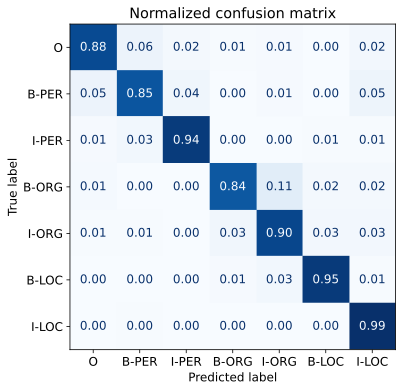

In [55]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

In [56]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, 
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,6.63,0.00,0.00,0.00,10.58,10.03,8.01,7.78,8.31,0.00,9.82,9.71,0.00,9.70,9.32,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.37,0.00,0.00,5.53,8.32,9.39,6.93,0.00,7.44,8.25,7.65,5.07,5.10,0.00,0.00,0.02,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.39,6.45,6.57,0.00,6.53,0.00,6.35,0.00,5.96,6.02,6.40,6.51,6.50,6.31,0.00


In [57]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.03,0.02,0.03,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.02,0.00,0.00,0.01,0.01,0.00,0.01,0.00


## 교차 언어 전이

In [58]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [59]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"[de] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['de']:.3f}")

[de] 데이터셋에서 [de] 모델의 F1-점수: 0.865


In [60]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [61]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [62]:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"[fr] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['fr']:.3f}")

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

[fr] 데이터셋에서 [de] 모델의 F1-점수: 0.698


In [63]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"[it] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['it']:.3f}")

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

[it] 데이터셋에서 [de] 모델의 F1-점수: 0.657


In [64]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"[en] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['en']:.3f}")

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

[en] 데이터셋에서 [de] 모델의 F1-점수: 0.592


### 제로 샷 전이가 유용할 때

In [65]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size
    
    trainer = Trainer(model_init=model_init, args=training_args,
        data_collator=data_collator, compute_metrics=compute_metrics,
        train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")
    
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [66]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [67]:
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Epoch,Training Loss,Validation Loss,F1
1,1.687000,1.231410,0.129340
2,1.126100,0.957126,0.305156
3,0.900700,0.864068,0.390639


,num_samples,f1_score
0,250,0.386871


In [68]:
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df.append(
        train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

Epoch,Training Loss,Validation Loss,F1
1,1.406800,0.931262,0.304701
2,0.757900,0.524862,0.641636
3,0.449700,0.452001,0.701425


Epoch,Training Loss,Validation Loss,F1
1,1.037700,0.470037,0.702128
2,0.374400,0.392393,0.750326
3,0.256200,0.380170,0.776971


Epoch,Training Loss,Validation Loss,F1
1,0.731200,0.398479,0.744547
2,0.308800,0.340194,0.781564
3,0.192900,0.336407,0.817484


Epoch,Training Loss,Validation Loss,F1
1,0.582000,0.320605,0.795599
2,0.269500,0.282946,0.823372
3,0.174800,0.294977,0.835545


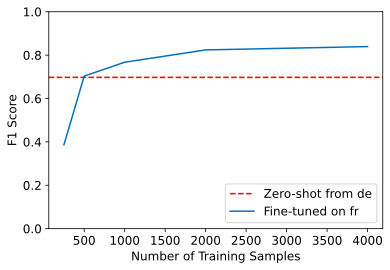

In [69]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

### 다국어에서 동시에 미세 튜닝하기

In [70]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

In [71]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [72]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Cloning https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-de-fr into local empty directory.


Download file pytorch_model.bin:   0%|          | 3.47k/1.03G [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 2.86k/2.86k [00:00<?, ?B/s]

Download file sentencepiece.bpe.model:   0%|          | 3.48k/4.83M [00:00<?, ?B/s]

Clean file training_args.bin:  35%|###4      | 1.00k/2.86k [00:00<?, ?B/s]

Clean file sentencepiece.bpe.model:   0%|          | 1.00k/4.83M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1
1,0.283700,0.185843,0.822912
2,0.144600,0.165134,0.846743
3,0.091700,0.172391,0.862445


Upload file training_args.bin: 100%|##########| 2.86k/2.86k [00:00<?, ?B/s]

To https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-de-fr
   15e72a0..c6c118b  main -> main



'https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-de-fr/commit/c6c118b0016200a443b0d08b1e238756eda5f069'

In [73]:
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"[{lang}] 데이터셋에서 [de-fr] 모델의 F1-점수: {f1:.3f}")

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

[de] 데이터셋에서 [de-fr] 모델의 F1-점수: 0.867


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

[fr] 데이터셋에서 [de-fr] 모델의 F1-점수: 0.863


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

[it] 데이터셋에서 [de-fr] 모델의 F1-점수: 0.807


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

[en] 데이터셋에서 [de-fr] 모델의 F1-점수: 0.679


In [74]:
corpora = [panx_de_encoded]

# 반복에서 독일어는 제외합니다.
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # 단일 언어 말뭉치에서 미세 튜닝합니다.
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # 딕셔너리에 F1-점수를 모읍니다.
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # 단일 언어 말뭉치를 corpora 리스트에 추가합니다.
    corpora.append(ds_encoded)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Cloning https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-fr into local empty directory.


Epoch,Training Loss,Validation Loss,F1
1,0.561800,0.248242,0.812148
2,0.258200,0.136809,0.906792
3,0.165300,0.103085,0.932455


Upload file pytorch_model.bin:   0%|          | 3.33k/1.03G [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 3.34k/4.83M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 2.86k/2.86k [00:00<?, ?B/s]

To https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-fr
   8a87573..df1c64b  main -> main

To https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-fr
   df1c64b..61f4c06  main -> main



  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Cloning https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-it into local empty directory.


Epoch,Training Loss,Validation Loss,F1
1,0.668000,0.288556,0.781759
2,0.258300,0.242057,0.820179
3,0.168200,0.240330,0.828947


Upload file pytorch_model.bin:   0%|          | 3.33k/1.03G [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 3.34k/4.83M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 2.86k/2.86k [00:00<?, ?B/s]

To https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-it
   edf74d4..ae681ed  main -> main

To https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-it
   ae681ed..4f16e1f  main -> main



  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Cloning https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-en into local empty directory.


Epoch,Training Loss,Validation Loss,F1
1,1.043500,0.516917,0.553191
2,0.471900,0.422413,0.662983
3,0.342400,0.384815,0.699448


Upload file pytorch_model.bin:   0%|          | 3.33k/1.03G [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 2.86k/2.86k [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 3.34k/4.83M [00:00<?, ?B/s]

To https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-en
   c1a7a70..98a030a  main -> main

To https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-en
   98a030a..bb189c7  main -> main



In [75]:
corpora_encoded = concatenate_splits(corpora)

In [76]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Cloning https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-all into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.81k/1.03G [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 2.86k/2.86k [00:00<?, ?B/s]

Clean file training_args.bin:  35%|###4      | 1.00k/2.86k [00:00<?, ?B/s]

Download file sentencepiece.bpe.model:   0%|          | 3.22k/4.83M [00:00<?, ?B/s]

Clean file sentencepiece.bpe.model:   0%|          | 1.00k/4.83M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1
1,0.296700,0.181654,0.828375
2,0.157600,0.152108,0.859724
3,0.099600,0.138667,0.885646


Upload file training_args.bin: 100%|##########| 2.86k/2.86k [00:00<?, ?B/s]

To https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-all
   fc8e680..a6f82c2  main -> main

To https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-all
   a6f82c2..c5464c4  main -> main



'https://huggingface.co/haesun/xlm-roberta-base-finetuned-panx-all/commit/a6f82c2d490b791ae6607445955a226b39828493'

In [77]:
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

In [78]:
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8647,0.6975,0.6572,0.5916
each,0.8647,0.8432,0.8328,0.7112
all,0.8692,0.8633,0.8668,0.7654


## 모델 위젯 사용하기

<img alt="A Hub widget" caption="Example of a widget on the Hugging Face Hub" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter04_ner-widget.png?raw=1" id="ner-widget"/>  

## 결론